In [7]:
#######################OBS
import cv2
import numpy
import argparse
import time
import re

from edgetpu.classification.engine import ClassificationEngine
from PIL import Image, ImageDraw, ImageFont

In [8]:
import re

def ReadLabelFile(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    ret = {}
    for line in lines:
        pair = re.split(r'[:\s]+', line.strip(), maxsplit=1)
        ret[int(pair[0])] = pair[1].strip()
    return ret


In [9]:
# find some useful color map
import PIL
#type(PIL.ImageColor.colormap.items())
import random
#colors = [(255,0,0,255) ,(0,255,0,255) ,(0,0,255,255),(255,255,0,255) ,(0,255,255,255) ,(255,255,255,255), \
#         (125,0,0,255) ,(125,255,0,255) ,(125,0,255,255),(125,255,0,255) ,(125,255,255,255) ,(125,255,255,255)]

colors = ['red','green','blue','yellow','magenta']

# Modelle (Select and init)

In [10]:
#Be sure to use the models labeled _edgetpu, as those are compiled for the accelerator - otherwise the model will run on the CPU and be much slower.
#https://coral.ai/models/
!ls /notebooks/all_models/*edgetpu*
print ("---- Label files (zu den Modellen) ----")
!ls /notebooks/all_models/*.txt

/notebooks/all_models/inception_v1_224_quant_edgetpu.tflite
/notebooks/all_models/inception_v2_224_quant_edgetpu.tflite
/notebooks/all_models/inception_v3_299_quant_edgetpu.tflite
/notebooks/all_models/inception_v4_299_quant_edgetpu.tflite
/notebooks/all_models/mobilenet_ssd_v1_coco_quant_postprocess_edgetpu.tflite
/notebooks/all_models/mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite
/notebooks/all_models/mobilenet_ssd_v2_face_quant_postprocess_edgetpu.tflite
/notebooks/all_models/mobilenet_v1_1.0_224_quant_edgetpu.tflite
/notebooks/all_models/mobilenet_v1_1.0_224_quant_embedding_extractor_edgetpu.tflite
/notebooks/all_models/mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite
/notebooks/all_models/mobilenet_v2_1.0_224_inat_insect_quant_edgetpu.tflite
/notebooks/all_models/mobilenet_v2_1.0_224_inat_plant_quant_edgetpu.tflite
/notebooks/all_models/mobilenet_v2_1.0_224_quant_edgetpu.tflite
---- Label files (zu den Modellen) ----
/notebooks/all_models/coco_labels.txt
/notebooks/all

In [11]:
#Hier werden 2 DetectionEngines gestartet (Objekte generell und Gesichter)

from edgetpu.detection.engine import DetectionEngine
from edgetpu.utils import dataset_utils

## https://coral.ai/docs/reference/edgetpu.detection.engine/
labels = ReadLabelFile("/notebooks/all_models/coco_labels.txt")
engine = DetectionEngine("/notebooks/all_models/mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite")

engine2 = DetectionEngine("/notebooks/all_models/mobilenet_ssd_v2_face_quant_postprocess_edgetpu.tflite")

#engine = DetectionEngine("/notebooks/coral/tflite/python/examples/detection/models/mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite")


# Some test data

In [5]:
from os import listdir
from os.path import isfile, join
import glob
mypath="/notebooks/data/"
#onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#onlyfiles
wasen=sorted(glob.glob(mypath + '*'))

# Load and crop image

ok
(851, 480)


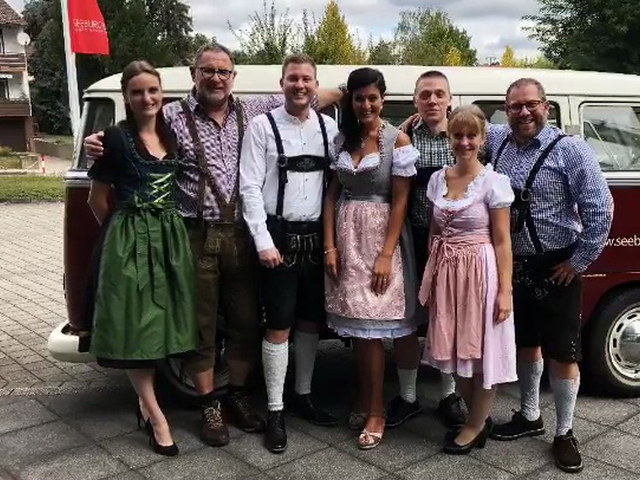

In [6]:
## load and crop image as required by the model

from base.image_tool  import ImageTool
import base.pose_tool as PoseTool

filename = wasen[104]
#filename = wasen[803]

# depends on model, e.g. 640, 320, 300
sizex = 640
sizey = 480

#sizex = 768 
#sizey = 576

#sizex = 1280 
#sizey = 720

img = ImageTool(filename=filename,h=sizey)


#img.testload()
#img.crop()
#img.testload()

img.printSize()

#img.crop(100,0,420,320)
#img.crop(0,0,320,320)

#img.crop(img.image.size[0] - sizex, 0, img.image.size[0], sizey)
img.crop(50, 0, 50 + sizex, sizey)

#screenshot = numpy.array(img.image)
display(img.image)

# Modelle

In [36]:
#results = engine.classify_with_image(image, top_k=1) 

#result = labels[results[0][0]] if results!=[] else 'None'

image = img.image
results = engine.detect_with_image(image,threshold= 0.2, top_k=20) 
results2 = engine2.detect_with_image(image,threshold= -0.1, top_k=7) 

len(results), len(results2)

(14, 4)

In [37]:
#results
for obj in results:
    print('-----------------------------------------')
    if labels:
      print(labels[obj.label_id])
    print('score =', obj.score)
    box = obj.bounding_box.flatten().tolist()
    print('box =', box)

-----------------------------------------
person
score = 0.98046875
box = [0.7637892961502075, 0.17641976475715637, 0.9215466976165771, 0.9316816329956055]
-----------------------------------------
person
score = 0.953125
box = [0.14244738221168518, 0.2977704703807831, 0.30607521533966064, 0.9503421783447266]
-----------------------------------------
person
score = 0.73046875
box = [0.49924618005752563, 0.17771512269973755, 0.6306636929512024, 0.919305145740509]
-----------------------------------------
person
score = 0.73046875
box = [0.6493188738822937, 0.22519204020500183, 0.7783574461936951, 0.9272336959838867]
-----------------------------------------
person
score = 0.66015625
box = [0.4022499918937683, 0.13254255056381226, 0.5142068862915039, 0.5727185010910034]
-----------------------------------------
person
score = 0.58203125
box = [0.28703007102012634, 0.12097188830375671, 0.3892139494419098, 0.5012987852096558]
-----------------------------------------
person
score = 0.58203

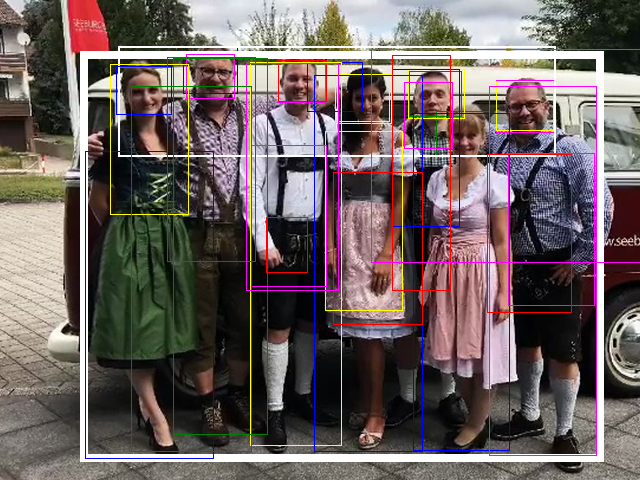

In [35]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

#https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
#https://stackoverflow.com/questions/54165439/what-are-the-exact-color-names-available-in-pils-imagedraw
# Print and draw detected objects.

def drawBoxes(img,results, minScore = -1):
    for obj in results:
        if obj.score < minScore: continue
        
        box = obj.bounding_box.flatten().tolist()
        x0 = box[0] * image.size[0]
        x1 = box[2] * image.size[0]
        y0 = box[1] * image.size[1]
        y1 = box[3] * image.size[1]
        
        draw = ImageDraw.Draw(img.image)
        rgba =  random.choice(colors) 
        draw.rectangle(((x0, y0), (x1, y1)),  outline=rgba)
        
drawBoxes(img,results2, -1)     
drawBoxes(img,results, -1)  
display(img.image)
    
if not results:
    print('No objects detected.')


In [9]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import random



#https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
#https://stackoverflow.com/questions/54165439/what-are-the-exact-color-names-available-in-pils-imagedraw

# Print and draw detected objects.

def getBBoxOfObjTypes(objtypes, results, labels):
    gx0 = gy0 = 99999
    gx1 = gy1 = 0
    
    for obj in results:
        if labels:
            if len(objtypes) == 0 or labels[obj.label_id] in objtypes:
                box = obj.bounding_box.flatten().tolist()
                x0 = box[0] * image.size[0]
                x1 = box[2] * image.size[0]
                y0 = box[1] * image.size[1]
                y1 = box[3] * image.size[1]
                
                if x0 < gx0 : gx0 = x0
                if y0 < gy0 : gy0 = y0
                if x1 > gx1 : gx1 = x1
                if y1 > gy1 : gy1 = y1
    return (gx0 , gy0, gx1, gy1)  

def getObjTypes(results):
    types = {}
    for obj in results:
        if labels:
            types[labels[obj.label_id]] = 0
    return types 


box= 523.1846237182617 410.9068250656128


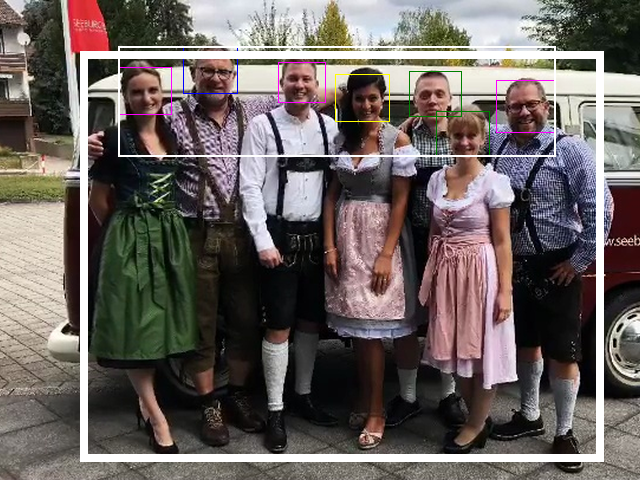

In [31]:
gx0 , gy0, gx1, gy1 = getBBoxOfObjTypes([], results2, labels)

img.drawBox(gx0 , gy0, gx1, gy1,color='white',width=2)

gx0 , gy0, gx1, gy1 = getBBoxOfObjTypes(['person'], results, labels)

#gx0 , gy0, gx1, gy1 = getBBoxOfObjTypes(['handbag'], results, labels)
#gx0 , gy0, gx1, gy1 = getBBoxOfObjTypes([], results, labels)

img.drawBox(gx0 , gy0, gx1, gy1,color='white',width=8)

sx=gx1-gx0
sy=gy1-gy0
print('box=',sx,sy)

display(img.image)

# Capture Image with webcam

In [ ]:
## ACHTUNG webcam muss lokal initialisiert werden
## webcam bei start verbunden
from base.image_tool import videoTool
video = videoTool()

In [ ]:
#from base.image_tool import videoLoop
#import time
try:
    video.loop()
except:
    display(video.image) 